In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
from pysit.util.util import *
from cycler import cycler
import h5py

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import copy as copy
import math
import os
import scipy.io as sio
from scipy.signal import hilbert
from shutil import copy2

import sys

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.gallery.layered_medium import three_layered_medium
from pysit.util.io import *
from pysit.util.compute_tools import *

from pysit.util.parallel import *

from mpi4py import MPI
from FTools.compute_adjoint_source import *
from FTools.compute_IC import *
from FTools.fang_plot import *


In [4]:
def plot_models2(Vels, Titles, cmap='jet'):
    n_v = len(Vels)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            vi = Vels[k]
            om = [0.0, 0.0]
            dm = [0.01, 0.01]
            nm = np.shape(vi)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k], cmap=cmap)
            k += 1
            
    return fig
    
        
    

In [5]:
def plot_trace(Vels, Legends, trace):
    fig = plt.figure()
    om = [0.0, 0.0]
    dm = [0.01, 0.01]
    nm = np.shape(Vels[0])
    output = odn2grid(om, dm, nm)
    Depth = output[0]
    Lateral = output[1] 
    for i in range(len(Legends)):
        vi = Vels[i]
        plt.plot(Depth, vi[:,trace])
        plt.title('x = ' + str(dm[0]*(trace-1)) +' km' )
        
    plt.legend(Legends)
    
    return fig
        
        

In [6]:
def Compute_wavefields(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    vt = vt.transpose()
    vt = np.reshape(vt, (np.prod(n_org), 1))

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    C.data = vt

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    # xrec_multiple = np.array(range(10, model_size[0]-10)) * model_delta[0]
    # xsrc_multiple = np.linspace(xrec_multiple[0], xrec_multiple[-1], num=10)
    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   
    # Generate synthetic Seismic data
    tt = time.time()
    base_model = solver.ModelParameters(m,{'C': C})
    print('strat generate data')

    generate_seismic_data(shots, solver, base_model)
                                   
    print('Data generation: {0}s'.format(time.time()-tt))
    
    Dobs = shots[0].receivers.data
    Dpred = []
    
    for i in idx:
        print(i)
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        C.data = data
        base_model = solver.ModelParameters(m,{'C': C})
        generate_seismic_data(shots, solver, base_model)
        Dpred.append(shots[0].receivers.data)
        
    
    return Dobs, Dpred
        
        
        
    

In [7]:
def create_animation_single(vt, fwave, Lateral, Depth, model_size, ntime, climc=None, ksmp=50):
    plt.figure()
    fig, ax = plt.subplots(1,2,figsize=(12,6))

    ims = []
    model_sizet = model_size
    model_sizec = [model_size[1], model_size[0]]
    DD = np.zeros(model_sizet)
    EE = np.zeros(model_sizet)
    vt = np.reshape(vt, model_size)
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        A = np.reshape(fwave[i], model_sizec)
        A = np.transpose(A)
        
        ax[0].set_title('Final model')
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vt, clim=climc[0], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        ax[1].set_title('Final wavefield')
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(A,clim=climc[1], 
                            extent=[Lateral[0], Lateral[model_size[1]-1], Depth[model_size[0]-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [8]:
def create_animation_model_update(Dirs, Titles, ntime=100, ksmp=1):
    plt.figure()
    ncol = 2
    nrow = len(Dirs) // 2
    climc = [1.5,5.5]
    fig, ax = plt.subplots(nrow, ncol, figsize=(12,6*nrow))
    Lateral = [0.0, 4.6]
    Depth = [0.0, 1.5]

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,ntime,ksmp):    
        
        fname = Dirs[0] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi0  = np.reshape(data,(563,251))
        vi0  = vi0.transpose()
        vi0  = vi0[50:201, 50:513]
        
        
        ax[0].set_title(Titles[0])
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Z [km]')
        im0=ax[0].imshow(vi0, clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)   
        im0.set_cmap('jet')
        
        fname = Dirs[1] + '/x_'+str(i)+'.mat'
        data = sio.loadmat(fname)['data']
        vi1  = np.reshape(data,(563,251))
        vi1  = vi1.transpose()
        vi1  = vi1[50:201, 50:513]
        
        ax[1].set_title(Titles[1])
        ax[1].set_xlabel('X [km]')
        ax[1].set_ylabel('Z [km]')
        im2=ax[1].imshow(vi1,clim=climc, 
                            extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]],
                            animated=True)
        im2.set_cmap('jet')
        
        
        ims.append([im0,im2])

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
    plt.close()
    
    return ani

In [9]:
def create_animation_model_transmission(Vels, Titles, frametitle=None,  ksmp=1):
    plt.figure()
    ncol = 3
    nrow = 2
    climc = [2.0,3.0]
    fig, ax = plt.subplots(nrow, ncol, figsize=(18,8))
    Lateral = [0.0, 8.0]
    Depth = [0.0, 4.0]
    nm = np.shape(Vels[0][0])

    ims = []
#     vt = np.transpose(vt)
    for i in range(0,len(Vels),ksmp):  
#     for i in range(0,1,ksmp):  
        k = 0
        im = []
        for j in range(0, ncol):
            for l in range(0, nrow):
                imk = plot_model(fig, ax[l][j], Vels[i][k], Lateral, Depth, nm, clim=climc, title_str=Titles[k],animated=True)
                im.append(imk)
                k+=1
        
        mt = fig.text(0.5, 0.5, frametitle[i], fontsize=15)
        im.append(mt)
        ims.append(im)

    ani = animation.ArtistAnimation(fig, ims, interval=500, blit=False, repeat_delay=1000)
    plt.close()
    
    return ani

In [10]:
def Create_Waves(ExpDir, idx):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]

    pmlx = PML(0.5, 100)
    pmlz = PML(0.5, 100)

    x_config = (0.0, model_size_phy_org[1], pmlx, pmlx)
    z_config = (0.0, model_size_phy_org[0], pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)
    m = CartesianMesh(d, n_org[1], n_org[0])
    
    C, C0, m, d = horizontal_reflector(m)

    model_size = m._shapes[False,True]
    model_delta = m.deltas

    xsrc_multiple = [1.5]
    xrec_multiple = [1.5]
    print(xsrc_multiple)
    zsrc_multiple = 0.5
    zrec_multiple = 5.5
    shots = equispaced_acquisition_given_locations(m,
                                                   RickerWavelet(8.0),
                                                   sources_x_locations=xsrc_multiple,
                                                   source_depth=zsrc_multiple,
                                                   source_kwargs={},
                                                   receivers_x_locations=xrec_multiple,
                                                   receiver_depth=zrec_multiple
                                                   )

    
    # Define and configure the wave solver
    trange = (0.0,4.0)
                                   
    solver = ConstantDensityAcousticWave(m,
                                         spatial_accuracy_order=4,
                                         trange=trange,
                                         kernel_implementation='cpp',
                                         max_C=3.2)

    solver.max_C = 3.2
                                   

    fname = ExpDir + '/x_' + str(idx) + '.mat'
    data = sio.loadmat(fname)['data']
    C.data = data
    wavefields=[]
    base_model = solver.ModelParameters(m,{'C': C})
    generate_seismic_data(shots, solver, base_model, wavefields=wavefields)
    
    v_final = np.reshape(data, model_size)
    v_final = np.transpose(v_final)
    v_true = np.ones(np.shape(v_final))
    
    
    return v_true, v_final, wavefields, Lateral, Depth, n_org, m
    
    

In [11]:
def plot_model_data(Dobs,Dpred,idx,ExpDir,clim=[2.0,3.0]):
    o_org = np.array([0.0,0.0])
    d_org = np.array([0.02, 0.02]);
    model_size_phy_org = np.array([6.0, 3.0])
    n_org = np.floor(model_size_phy_org/d_org)
    n_org = n_org.astype(int) + 1
    vel_true = 2.5
    output = odn2grid(o_org, d_org, n_org)
    Depth = output[0]
    Lateral = output[1]
    vt = np.ones(n_org) * vel_true
    
    n_row = 1 + len(Dpred)
    n_col = 4
    
    t_smp = np.linspace(0.0,4.0,len(Dobs))
    plt.figure()
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,5*n_row))
    plot_model(fig, ax[0][0], vt, Lateral, Depth, n_org, clim=clim, title_str='True')
    plot_data(ax[0][1], Dobs, t_smp, title_str='Dobs')
    
    for i_row in range(1,n_row):
        i = idx[i_row-1]
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        vi   = np.reshape(data, [n_org[1], n_org[0]])
        vi   = np.transpose(vi)
        plot_model(fig, ax[i_row][0], vi, Lateral, Depth, n_org, clim=clim, title_str='x_'+str(i))
        plot_data(ax[i_row][1], Dpred[i_row-1], t_smp, title_str='Dpred_'+str(i))
        plot_data(ax[i_row][2], Dpred[i_row-1]-Dobs, t_smp, title_str='Dpred_'+str(i)+' - Dobs')
        plot_data(ax[i_row][3], Dpred[i_row-1], t_smp)
        plot_data(ax[i_row][3], Dobs, t_smp)
        ax[i_row][3].legend(['Dpred','Dobs'])
        
        
def plot_model_data_misfit(ExpDir):
    M_error = np.zeros(31)
    for i in range(0,31):
        fname = ExpDir + '/x_' + str(i) + '.mat'
        data = sio.loadmat(fname)['data']
        M_error[i] = np.linalg.norm(data-2.5)
        
    fname = ExpDir + '/objective_value_ot_l.mat'
    data, o, d, n = read_data(fname)
    fig,ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].plot(np.array(range(0,31)), M_error)
    ax[0].set_title('Model_error')
    ax[0].set_xlabel('Iteration')
    
    ax[1].plot(np.array(range(0,30)), data.flatten())
    ax[1].set_title('Objective')
    ax[1].set_xlabel('Iteration')
    
    
        
        
        
    
    
    

In [12]:
def plot_models(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result.mat'
            vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out

def plot_models_EI(DirSub, Titles):
    n_v = len(DirSub)
    n_col = 2
    n_row = n_v // n_col
    
    fig,ax = plt.subplots(n_row,n_col,figsize=(20,4*n_row))
    k = 0
    v_out = []
    for i in range(0,2):
        for j in range(0,n_row):
            fname = DirSub[k]+'/result_EI.mat'
            A = sio.loadmat(fname)
            vi = A['data']
            om = [0.0,0.0]
            dm = [0.01,0.01]
            nm = np.shape(vi)
#             vi, om, dm, nm = read_data(fname)
            output = odn2grid(om, dm, nm)
            Depth = output[0]
            Lateral = output[1]
            clim_v = [1.5,5.5]
            plot_model(fig, ax[j][i], vi, Lateral, Depth, nm, clim=clim_v, title_str=Titles[k])
            k += 1
            v_out.append(vi)
    
    return v_out
    

In [13]:
def plot_model_error(DirSub, Legends):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    MEF=[]
    for i in range(len(LSDirSub)):
        fname = DirSub[i] + '/model_error.mat'
        ME, o, d, n = read_data(fname)
        ME = ME.flatten()
        ax[0].plot(ME)
        MEF.append(ME[-1])
        
    ax[0].legend(Legends)
    ax[0].set_title('Relative model errors')
    ax[0].set_xlabel('Iteration')
    ax[1].plot([2,3,4,5],MEF)
    ax[1].set_xlabel('Cutting frequency [Hz]')
    ax[1].set_title('Relative model error v.s. cutting frequency')
    
    return MEF
        
        

In [14]:
def savefig2(name):
    plt.savefig(name + '.pdf',bbox_inches='tight')
    plt.savefig(name + '.eps',bbox_inches='tight')
    plt.savefig(name + '.png',bbox_inches='tight')

In [15]:
def savefig(name):
    plt.savefig(name + '.pdf')
    plt.savefig(name + '.eps')
    plt.savefig(name + '.png')

In [16]:
if __name__ == '__main__':
    RootDir = '/wavedata/Zhilong/ExxonProject/ConstantModel/ExxonMeeting20190314'
    FigDir = '/math/home/fangzl/Project/Figure/ExxonProject/Paper/Journal/Transmission'
    

## 2. Starting frequency band comparison

In this example, we compare the performances of different algorithms with respect to the change of the starting frequency band. We test each method with starting frequency ranging from 1.7 Hz to 2.4 Hz.

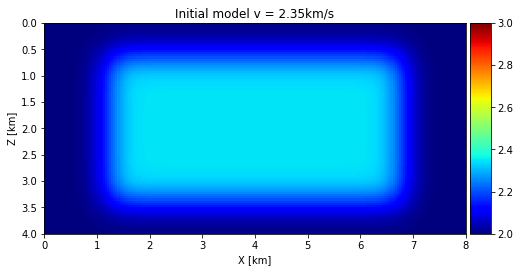

In [17]:
    ExpDir = '/wavedata/Zhilong/ExxonProject/ConstantModel/ExxonMeeting20190314/OneEvent_SF_PGD_Ormsby'
    FigDir1 = './SFMError'
    SubDir1 = ['1_7', '1_8', '1_9', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5']
    SubDir2 = ['LS', 'EIP1', 'CC', 'OT_L', 'OT_E', 'OT_Q']
    Labels2 = ['LS', 'ei', 'correlate', 'ot_l', 'ot_e', 'ot_q']
#     SubDir2 = ['CC', 'EI', 'LS', 'OT_E', 'OT_L', 'OT_Q']
#     Labels2 = ['correlate', 'ei', 'LS', 'ot_e', 'ot_l', 'ot_q']
    
#     SubDir1 = ['1_6', '2_0', '2_1', '2_2',]
#     SubDir2 = ['CC', 'EI', 'LS', 'OT_E', 'OT_L', 'OT_Q']
    Files = ['/result.mat', '/result.mat', '/result.mat', '/result.mat', '/result.mat', '/result.mat',]
    
    vifile = ExpDir + '/Exp' + SubDir1[0] + '/' + SubDir2[0] + '/initial.mat'
    vtfile = ExpDir + '/Exp' + SubDir1[0] + '/' + SubDir2[0] + '/true.mat'
    vi, om, dm, nm = read_data(vifile)
    vt, ot, dt, nt = read_data(vtfile)
    nm = [nm[1], nm[0]]
    vi = np.reshape(vi,nm)
    
    output = odn2grid(om, dm, nm)
    Depth = output[0]
    Lateral = output[1]
    clim_v = [2.0,3.0]
    
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    plot_model(fig, ax, vi, Lateral, Depth, nm, clim=clim_v, title_str='Initial model v = 2.35km/s')
#     savefig(FigDir1 + '/vin')

    

In this example, we use the ormsby wavelet whose frequency spectrum is approximately flat in a certain frquency band. The ormsby wavelet has the following expression:

$\text{Ormsby}(t) = [\frac{f_4^2}{f_4-f_3}\text{sinc}^2(f_4t) - \frac{f_3^2}{f_4-f_3}\text{sinc}^2(f_3t)] - [\frac{f_2^2}{f_2-f_1}\text{sinc}^2(f_2t) - \frac{f_1^2}{f_2-f_1}\text{sinc}^2(f_1t)].$ 

We select $f_1 = 0.5$Hz, $f_2 = 1.0$Hz, $f_3 = 10.0$Hz, $f_4 = 15.0$Hz, therefore, we obtain the source wavelet as follows:

./SFMError/OrmsbySource


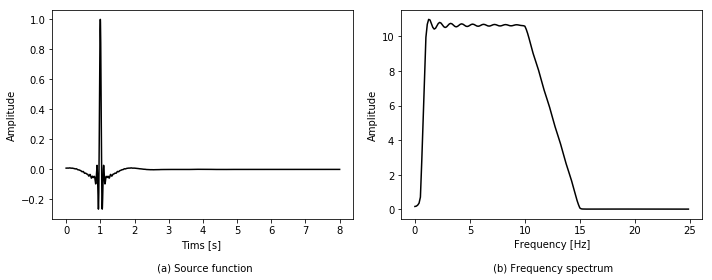

In [18]:
f1 = 0.5
f2 = 1.0
f3 = 10.0
f4 = 15.0
fig,ax=plt.subplots(1,2,figsize=(10,4))
f_src2=OrmsbySource(f1,f2,f3,f4,t_shift=1.0)
ts = np.linspace(0.0, 8.0, 2001)
src = f_src2(ts)
ax[0].plot(ts,src,color='k')
ax[0].set_xlabel('Tims [s] \n \n (a) Source function')
ax[0].set_ylabel('Amplitude')

spectrum = np.abs(np.fft.fft(src))
freq = np.linspace(0.0, 2000.0/8.0, 2001)
ax[1].plot(freq[0:200], spectrum[0:200],color='k')
ax[1].set_xlabel('Frequency [Hz]\n \n (b) Frequency spectrum')
ax[1].set_ylabel('Amplitude')
print(FigDir1 + '/OrmsbySource')
plt.rc('axes', titlesize=24)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.tight_layout()

# savefig(FigDir1 + '/OrmsbySource')


In [19]:
    model_error = np.zeros((len(SubDir1), len(SubDir2)))
    model_error_f = np.zeros((len(SubDir1), len(SubDir2)))
    Vels = []
    Vels_f = []
    ERRORS = dict()
    for i in range(len(SubDir2)):
        ERRORS[SubDir2[i]] = []
    for i in range(len(SubDir1)):
        Velsi = []
        Velsi_f = []
        for j in range(len(SubDir2)):
            vij_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + Files[j]
            vij, otmp, dtmp, ntmp = read_data(vij_file)
            model_error_f[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten())/ np.linalg.norm(vt.flatten())
            Velsi_f.append(vij.transpose())
            
            
            Error = 1e10
            opt_k = 0
            Errors = np.ones(101)
            for k in range(101):
                vijk_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/xm/x_' + str(k) + '.mat'
                A = sio.loadmat(vijk_file)
                vijk = A['data']
                Errori = np.linalg.norm(vijk.flatten() - vt.flatten())
                Errors[k] = Errori
                if Errori < Error:
                    Error = Errori
                    vij = vijk
                    opt_k = k
            write_data(ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/model_error.mat',Errors, 0,1,len(Errors))
            ERRORS[SubDir2[j]].append(Errors)
                    
            print(opt_k,end=",  ")
#             vij, otmp, dtmp, ntmp = read_data(vij_file)
            vij = vij.transpose()
            model_error[i][j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten()) / np.linalg.norm(vt.flatten())
            Velsi.append(np.reshape(vij.transpose(),[101,201]))
        Vels.append(Velsi)
        Vels_f.append(Velsi_f)

100,  100,  12,  100,  100,  100,  100,  100,  14,  100,  100,  100,  100,  100,  15,  100,  100,  100,  100,  100,  16,  100,  100,  100,  100,  100,  19,  100,  100,  100,  100,  100,  22,  100,  100,  100,  0,  100,  23,  100,  100,  100,  0,  100,  27,  3,  100,  100,  0,  100,  24,  0,  0,  100,  

9


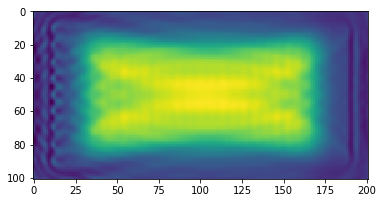

In [20]:
tmp = np.reshape(vij,[101,201])
plt.imshow(tmp)
print(len(ERRORS[SubDir2[0]]))

#### Iteration history of each experiment

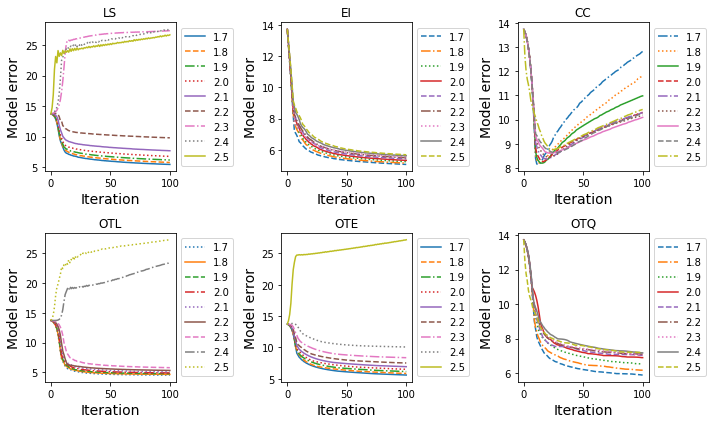

In [21]:
from itertools import cycle
fig,ax = plt.subplots(2,3,figsize=[10,6])
SubDir2tmp = ['LS','EI','CC','OTL','OTE','OTQ']
colortmp = ['b','g','r','c','m','y','k']
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for k in range(len(SubDir2)):
    for i in range(9):
        row = k//3
        col = k-3*row
        strtmp = str(1.7+i*0.1)
        ax[row][col].plot(ERRORS[SubDir2[k]][i],next(linecycler),label=strtmp)
        ax[row][col].set_title(SubDir2tmp[k],fontsize=12)
        ax[row][col].set_xlabel('Iteration')
        ax[row][col].set_ylabel('Model error')
        ax[row][col].legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# savefig(FigDir1 + '/ModelErrorIter')

In [27]:
Ftitle = []
climc = [2.0,3.0]

Lateral = [0.0, 8.0]
Depth = [0.0, 4.0]
Ftitle = ['Initial model', '2.2 Hz', '2.3 Hz', '2.4 Hz', '2.5 Hz']
FrameValue = [5, 6, 7, 8]

for j in range(len(SubDir2)):
    fig, ax = plt.subplots(5,1,figsize=[6,24])
    for i in range(len(FrameValue)+1):
        if i == 0:
            veli = vi 
        else:            
            FrameIndex = FrameValue[i-1]
            veli = Vels[FrameIndex][j]
    #     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
        im1=ax[i].imshow(veli, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
        ax[i].set_title(Ftitle[i])
        ax[i].set_xlabel('X [km]')
        ax[i].set_ylabel('Z [km]')
    plt.tight_layout()
    plt.close()
#     savefig2(FigDir1 + '/ModelsCmpSF'+SubDir2[j])

    

Text(0,0.5,'Relative model error $\\frac{\\|\\mathbf{m}_{t}-\\mathbf{m}_{b}\\|_2}{\\|\\mathbf{m}_{t}\\|_2}$')

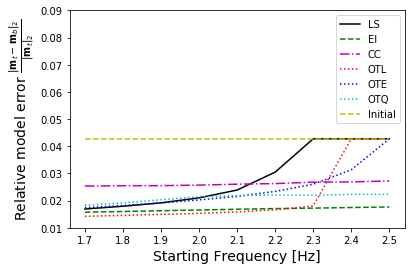

In [23]:
Error_ini = np.linalg.norm(vi.flatten()-vt.flatten()) / np.linalg.norm(vt.flatten())
xx = [1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
# clrs_list=['k','b','m','r','g','c'] # list of basic colors
# styl_list=['-','--','-.',':','-.', ':'] # list of basic linestyles
clrs_list=['k','g','m','r','b','c'] # list of basic colors
styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles
# Legend_STR = ['CC', 'EI', 'LS', 'OTE', 'OTL', 'OTQ', 'Initial']
Legend_STR = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ', 'Initial']
plt.figure()
for i in range(len(SubDir2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,model_error[:,i],color=clrr,ls=styl)
# plt.legend(SubDir2) 
plt.plot(xx, np.ones(len(xx))*Error_ini,color='y',ls='--')
plt.legend(Legend_STR)
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Starting Frequency [Hz]')
plt.ylim([0.01,0.09])
# plt.ylabel('Relative model error')
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{b}\|_2}{\|\mathbf{m}_{t}\|_2}$')
# plt.title('Model Error')
# savefig(FigDir1 + '/model_error2')

Text(0,0.5,'Relative model error $\\frac{\\|\\mathbf{m}_{t}-\\mathbf{m}_{f}\\|_2}{\\|\\mathbf{m}_{t}\\|_2}$')

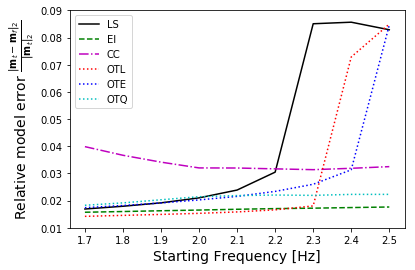

In [24]:
ME1 = np.ones((len(SubDir1), len(SubDir2)))
Vels = []
Objs = []
for i in range(len(SubDir1)):
    Velsi = []
    Objsi = []
    for j in range(len(SubDir2)):
        vfile = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + Files[j]
        vij, oij, dij, nij = read_data(vfile)
        Velsi.append(vij)
        ME1[i, j] = np.linalg.norm(vij.transpose().flatten() - vt.flatten())
        Objsi_file = ExpDir + '/Exp' + SubDir1[i] + '/' + SubDir2[j] + '/objective_value_' + Labels2[j] + '.mat'
        objsi, otmp, dtmp, ntmp = read_data(Objsi_file)
        Objsi.append(objsi.transpose())
            
    Objs.append(Objsi)
    
    Vels.append(Velsi)

xx = [1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
clrs_list=['k','g','m','r','b','c'] # list of basic colors
styl_list=['-','--','-.',':',':', ':'] # list of basic linestyles
# Legend_STR = ['CC', 'EI', 'LS', 'OTE', 'OTL', 'OTQ', 'Initial']
Legend_STR = ['LS', 'EI', 'CC', 'OTL', 'OTE', 'OTQ']
plt.figure()
for i in range(len(SubDir2)):
    clrr=clrs_list[i]
    styl=styl_list[i]
    plt.plot(xx,ME1[:,i]/np.linalg.norm(vt.flatten()),color=clrr,ls=styl)
# plt.legend(SubDir2) 
plt.legend(Legend_STR)
# plt.xticks(np.array(range(8)), ('1.6','1.7','1.8','1.9','2.0','2.1','2.2','2.3'))
plt.xlabel('Starting Frequency [Hz]')
plt.ylabel('Relative model error')
plt.ylim([0.01,0.09])
plt.ylabel(r'Relative model error $\frac{\|\mathbf{m}_{t}-\mathbf{m}_{f}\|_2}{\|\mathbf{m}_{t}\|_2}$')
# plt.title('Model Error')
# savefig(FigDir1 + '/model_error')


In [28]:
Ftitle = []
climc = [2.0,3.0]

Lateral = [0.0, 8.0]
Depth = [0.0, 4.0]
Ftitle = ['Initial model', '2.2 Hz', '2.3 Hz', '2.4 Hz', '2.5 Hz']
FrameValue = [5, 6, 7, 8]

ERRORS[SubDir2[k]][i]
for j in range(len(SubDir2)):
    fig, ax = plt.subplots(5,1,figsize=[6,24])
    for i in range(len(FrameValue)+1):
        if i == 0:
            veli = vi 
        else:            
            FrameIndex = FrameValue[i-1]
            veli = Vels_f[FrameIndex][j]
            Errors_tmp = ERRORS[SubDir2[j]][FrameIndex]
    #     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
        im1=ax[i].imshow(veli, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
        ax[i].set_title(Ftitle[i])
        ax[i].set_xlabel('X [km]')
        ax[i].set_ylabel('Z [km]')
        if i > 0:
            if Errors_tmp[60:80].mean() > Errors_tmp[80:100].mean():
                ax[i].scatter(0.5,0.25,s=400,marker='*',color='green')
            else:
                ax[i].scatter(0.5,0.25,s=400,marker='*',color='yellow')
            
    plt.tight_layout()
    plt.close()
#     savefig2(FigDir1 + '/ModelsCmpSF'+SubDir2[j]+'fm')

    

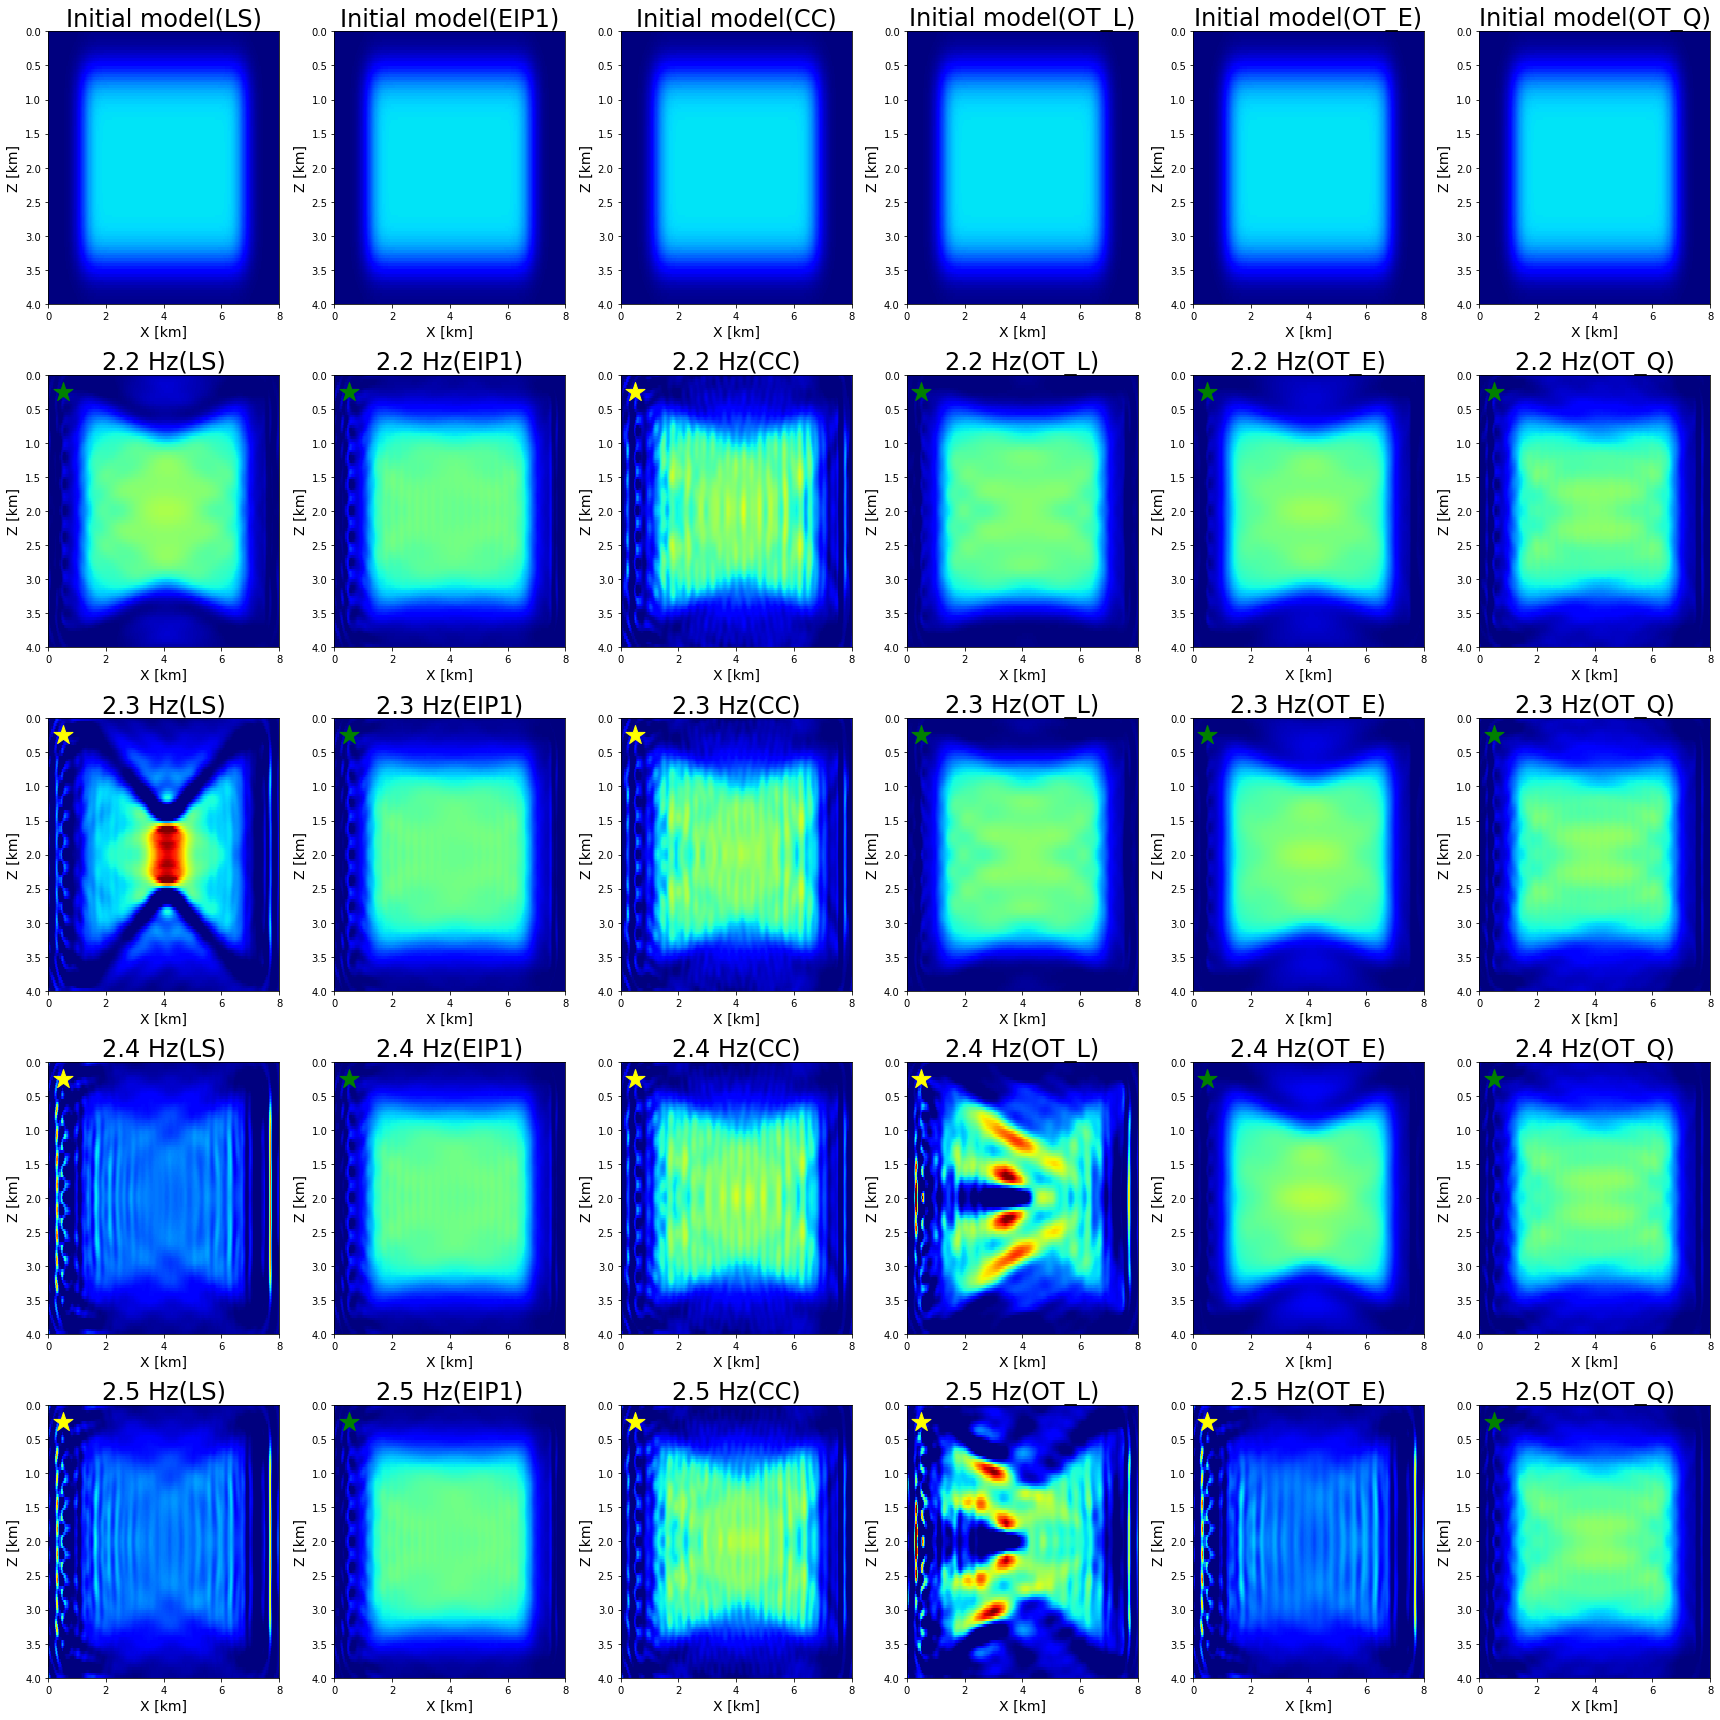

In [36]:
fig, ax = plt.subplots(5,len(SubDir2),figsize=[24,24])
for j in range(len(SubDir2)):
    
    for i in range(len(FrameValue)+1):
        if i == 0:
            veli = vi 
        else:            
            FrameIndex = FrameValue[i-1]
            veli = Vels_f[FrameIndex][j]
            Errors_tmp = ERRORS[SubDir2[j]][FrameIndex]
    #     imk = plot_model(fig, ax[i], Vels_ini[FrameIndex], Lateral, Depth, nm, clim=climc, title_str=Ftitle[i])
        im1=ax[i][j].imshow(veli, extent=[Lateral[0], Lateral[-1], Depth[-1], Depth[0]], clim=clim_v, interpolation='nearest', aspect='auto', cmap='jet')
        ax[i][j].set_title(Ftitle[i] + '('+SubDir2[j]+')')
        ax[i][j].set_xlabel('X [km]')
        ax[i][j].set_ylabel('Z [km]')
        if i > 0:
            if Errors_tmp[60:80].mean() > Errors_tmp[80:100].mean():
                ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='green')
            else:
                ax[i][j].scatter(0.5,0.25,s=400,marker='*',color='yellow')
            
    plt.tight_layout()